In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import RobustScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.3.0


In [4]:
data = pd.read_csv('SPY.csv', index_col=0)
data.describe()

,Open,High,Low,Close,Adj Close,Volume,adj_factor,Adj Open,Adj High,Adj Low,Amount,Return
count,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000,4.940000e+03,4940.000000,4940.000000,4940.000000,4940.000000,4.940000e+03,4939.000000
mean,154.916778,155.806689,153.932967,154.915397,130.080000,1.131555e+08,0.812321,130.078555,130.806185,129.273872,1.670164e+10,0.000215
std,55.392654,55.455574,55.300664,55.399593,61.369875,9.924321e+07,0.090854,61.360605,61.498516,61.191653,1.263130e+10,0.012023
min,67.949997,70.000000,67.099998,68.110001,53.947025,1.436600e+06,0.680423,53.820293,55.444013,53.147048,2.102599e+08,-0.103637
25%,115.087498,115.914999,114.237499,115.035000,86.590834,4.774008e+07,0.729271,86.563831,87.135411,85.990860,5.662622e+09,-0.004688
50%,135.365005,136.359375,134.345001,135.367500,104.276886,8.471245e+07,0.806054,104.382847,105.009414,103.567459,1.585927e+10,0.000637
75%,194.987495,195.797501,193.922504,194.922497,174.989334,1.524191e+08,0.892026,174.750644,175.675158,173.599633,2.352806e+10,0.005786
max,301.880005,302.230011,300.850006,302.010010,296.099121,8.710263e+08,0.980428,295.971668,296.314816,294.961829,9.561302e+10,0.135577


### Data Preprocessing
* We will use last nlag days price & volume data to predict the next day's return.
* At day $t$, $y = return_{t+1}$. $X = contains close[t-nlag:t], high[t-nlag:t], low[t-nlag:t]...$. Assume we have T samples, shape of y is (T,), shape of X is(T, nlag)
* Since we predict return(stationary), we need to make features also stationary. Therefore we devide all the prices by close[t-nlag-1], so price trend information is kept but level information is dropped. We also devide volume by its $window-$days rolling average to make it stationary.

In [5]:
# create X & y

def series_to_supervised(data, lags=10, columns=None, burnout=100):
    """
    Create  X: a 3D array, in shape (nsample, lags, nfeatures)
            Y: a 2D array, in shape (nsample, 1)
    """
    if not columns:
        columns = ['Adj Open', 'Adj High', 'Adj Low', 'Adj Close', 'Amount']
    nsample, nfeatures = len(data), len(columns)
    
    Y = data['Return'].values
    X = np.zeros((nsample, lags, nfeatures))
    for i in range(1, lags+1):
        X[:, lags-i, :] = data[columns].shift(i).values
    
    return X[lags+burnout:], Y[lags+burnout:]

def normalize_X(X, data, lags=10, burnout=100, window=50):
    """
    This part will normalize features in X.
    To normalize the prices, we will calculate the ratio of price to the close of lag+1 day before
    To normalize the amount, we will calculate the ratio of amount to its 50 days' rolling average
    args:
        X: feature data
        data: the price&volume dataframe
        window: the window for the rolling average
    return:
        normalized X
    """
    price_o = data['Adj Close'].shift(lags + 1).values[lags+burnout:].reshape(-1, 1, 1)
    avg_amt = data['Amount'].rolling(window).mean().shift(1).values[lags+burnout:].reshape(-1, 1)
    
    X[:, :, :-1] = X[:, :, :-1] / price_o # normalize the prices
    X[:, :, -1] = X[:, :, -1] / avg_amt # normalize the amount
    
    return X

def normalize_y(Y):
    """
    Apply robust scaler to Y and Clip the extremums of Y.
    return:
        y: normalized version
    """
    scaler = RobustScaler()
    scaler.fit(Y.reshape(-1,1))
    Y[Y > scaler.center_ + 2.5*scaler.scale_] = scaler.center_ + 2.5*scaler.scale_
    Y[Y < scaler.center_ - 2.5*scaler.scale_] = scaler.center_ - 2.5*scaler.scale_
    return Y * 100

def Prepare_data(data, lags=10, columns=None, burnout=100, window=50, train_size=2000):
    """
    A wrapper for data preparation.
    """
    X, Y = series_to_supervised(data, lags, columns, burnout)
    X = normalize_X(X, data, lags, burnout, window)
    train_label, test_label = Y[:train_size], Y[train_size:]*100
    train_label = normalize_y(train_label)
    cache = {
        'train_data': X[:train_size],
        'train_label': train_label,
        'test_data': X[train_size:],
        'test_label': test_label
#         'scaler': scaler
    }
    return cache

In [6]:
nlags = 20 # Look back 20 days

cache = Prepare_data(data, 20, train_size=-1200)

### Look at feature correlations
* the first day: not very correlated
* the last day: prices are highly correlated since the difference between high&close is very small compared to the price movement in past 20 days.

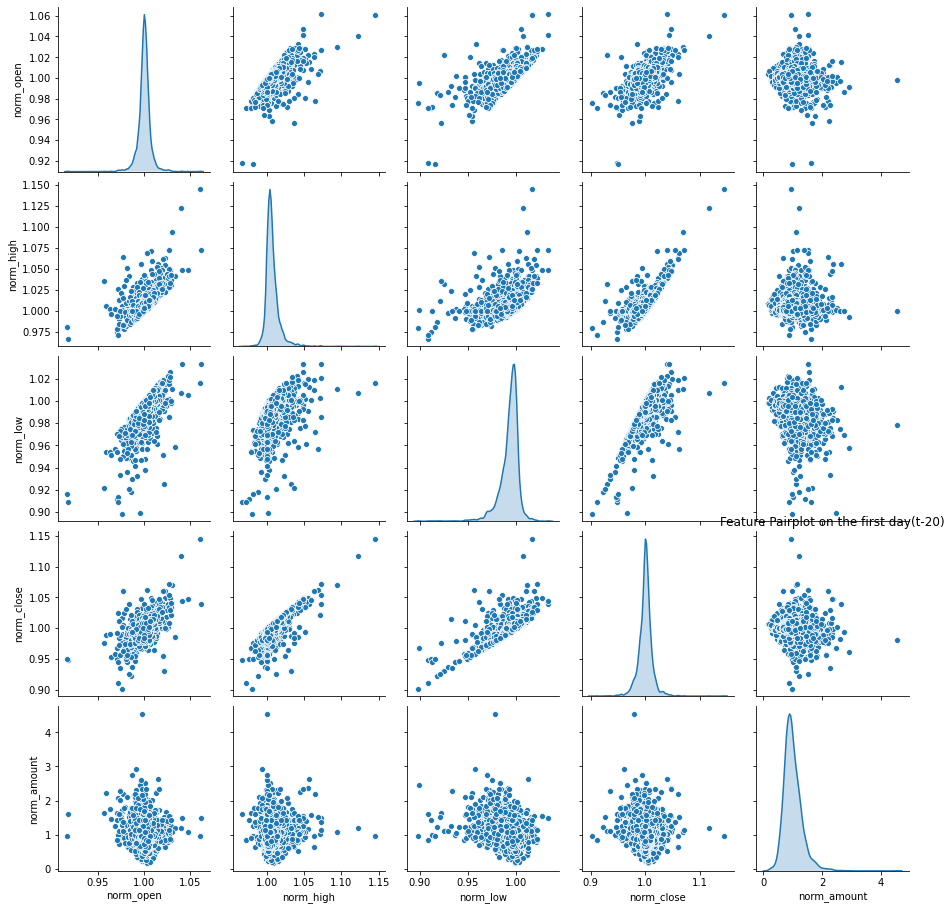

In [12]:
# Feature Pairplot on the first day (t-20)
features = pd.DataFrame(cache['train_data'][:,0,:], columns=['norm_'+i for i in ['open','high','low','close','amount']])
sns.pairplot(features, diag_kind="kde")
plt.show()

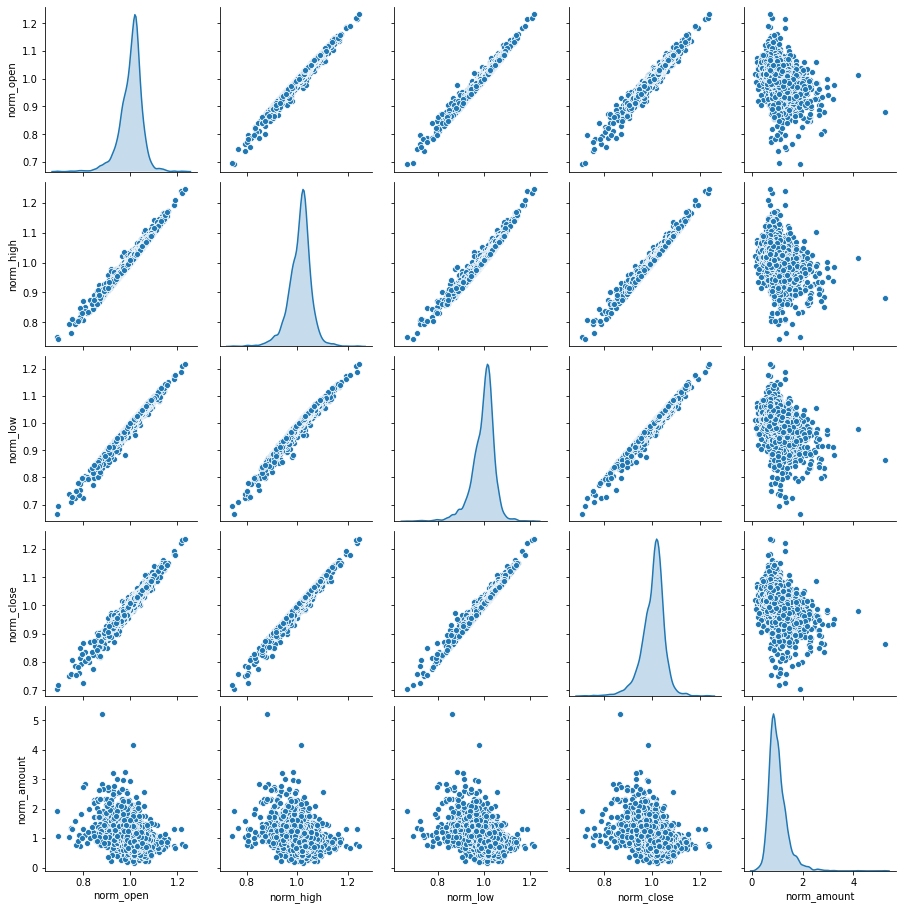

In [14]:
# Feature Pairplot on the last day (t-1) : prices highly correlated
features = pd.DataFrame(cache['train_data'][:,-1,:], columns=['norm_'+i for i in ['open','high','low','close','amount']])
sns.pairplot(features, diag_kind="kde")
plt.show()

## Train the model

In [7]:
import keras.backend as K
def right_direction(y_true, y_pred):
    """
    This is a customed metric. It calculate the ratio of predictions having the same sign as labels.
    """
    length = K.shape(y_true)[0]
    pmn = K.sum(K.sign(y_true * y_pred)) ## positive - negative
    ppn = K.sum(K.abs(K.sign(y_true * y_pred)))
    wrong_rate = (ppn + pmn) /2/ ppn
    return wrong_rate * 100

def plot_history(history):
    """
    This function is used to plot the training curve.
    """
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig, ax = plt.subplots()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('MSE')
    ax.plot(hist['epoch'], hist['loss'],
           label='Train Error')
    ax.legend()
    ax1 = ax.twinx()
    ax1.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error', color='r')
    #   plt.ylim([0,])
    ax1.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.plot(hist['epoch'], hist['right_direction'],
           label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_right_direction'],
           label = 'Val Accuracy', color='r')
    #   plt.ylim([0,20])
    plt.legend()
    plt.show()

def build_model1(units=12, nlags=10, seed=1):
    """
    Model 1: a single LSTM + 4 Dense layes with BatchNorm & Dropout
    """
    model = keras.Sequential([
        layers.LSTM(units=units, activation='tanh', recurrent_activation='sigmoid', return_sequences=False, input_shape=(nlags, 5)),
        layers.Dropout(rate=0.2),
        layers.Dense(10, activation='relu'),
        layers.BatchNormalization(trainable=True),
        layers.Dense(10, activation=tf.nn.relu),
        layers.Dense(5, activation=tf.nn.relu),
        layers.Dense(1)
    ])
#     lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=100, decay_rate=0.9)
    lr=0.001
    
    optimizer = tf.keras.optimizers.Adam(lr)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=[right_direction, 'mae'])
    return model

def build_model2(units=12, nlags=10, seed=1):
    """
    Model 2: a double layer LSTM + 3 Dense layers with BatchNorm & Dropout
    """
    tf.random.set_seed(seed)
    model = keras.Sequential([
        layers.LSTM(units=units, activation='tanh', recurrent_activation='sigmoid', return_sequences=True, input_shape=(nlags, 5)),
        layers.Dropout(rate=0.2),
        layers.LSTM(units=units, activation='tanh', recurrent_activation='sigmoid'),
        layers.BatchNormalization(trainable=True),
        layers.Dense(10, activation=tf.nn.relu),
        layers.Dense(5, activation=tf.nn.relu),
        layers.Dense(1)
    ])

#     lr = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=100, decay_rate=0.9)
    lr=0.001
    
    optimizer = tf.keras.optimizers.Adam(lr)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=[right_direction, 'mae'])
    return model

In [8]:
initial_epoch=0
tf.random.set_seed(0)
model = build_model2(nlags=nlags) # create a double layer LSTM
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 12)            864       
_________________________________________________________________
dropout (Dropout)            (None, 20, 12)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 12)                1200      
_________________________________________________________________
batch_normalization (BatchNo (None, 12)                48        
_________________________________________________________________
dense (Dense)                (None, 10)                130       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6

Epoch 1/200
1/1 [==============================] - 1s 603ms/step - loss: 1.3565 - right_direction: 50.7277 - mae: 0.8667 - val_loss: 0.5489 - val_right_direction: 50.8424 - val_mae: 0.5582
Epoch 2/200
1/1 [==============================] - 0s 415ms/step - loss: 1.3504 - right_direction: 49.8614 - mae: 0.8664 - val_loss: 0.5491 - val_right_direction: 50.9783 - val_mae: 0.5584
Epoch 3/200
1/1 [==============================] - 1s 532ms/step - loss: 1.3502 - right_direction: 50.7277 - mae: 0.8668 - val_loss: 0.5491 - val_right_direction: 50.8424 - val_mae: 0.5585
Epoch 4/200
1/1 [==============================] - 0s 423ms/step - loss: 1.3492 - right_direction: 50.1733 - mae: 0.8647 - val_loss: 0.5490 - val_right_direction: 50.8424 - val_mae: 0.5586
Epoch 5/200
1/1 [==============================] - 0s 398ms/step - loss: 1.3507 - right_direction: 50.5891 - mae: 0.8650 - val_loss: 0.5489 - val_right_direction: 50.8424 - val_mae: 0.5586
Epoch 6/200
1/1 [==============================] - 0s 4

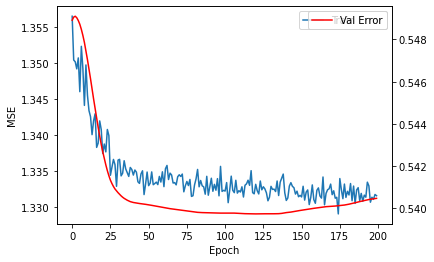

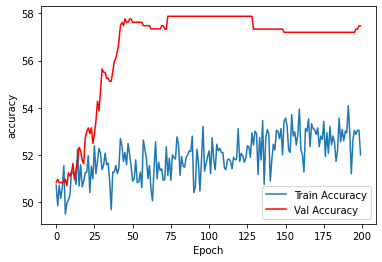

In [10]:
train_data = cache['train_data']
train_label = cache['train_label']

class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

# log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

EPOCHS = 200
tf.random.set_seed(1)
history = model.fit(
    train_data, train_label, batch_size=5000, shuffle=False ,epochs=EPOCHS, validation_split=0.2, 
    verbose=1, callbacks=[PrintDot()])#, initial_epoch=initial_epoch)
initial_epoch += EPOCHS
print(initial_epoch)
plot_history(history)

In [22]:
model.load_weights('../Weights/weights01')

In [16]:
length = int(len(cache['train_label']) * 0.8)
np.var(cache['train_label'][:length])

1.3343695469124586

(1200,) (1200,)


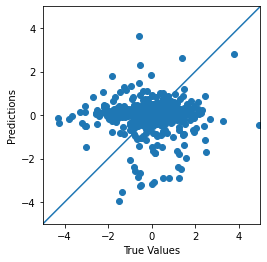

In [23]:
test_data = cache['test_data']
test_labels = cache['test_label']
test_predictions = model.predict(test_data).flatten()
print(test_labels.shape, test_predictions.shape)
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([-5, 5])
plt.ylim([-5, 5])
_ = plt.plot([-5, 5], [-5, 5])


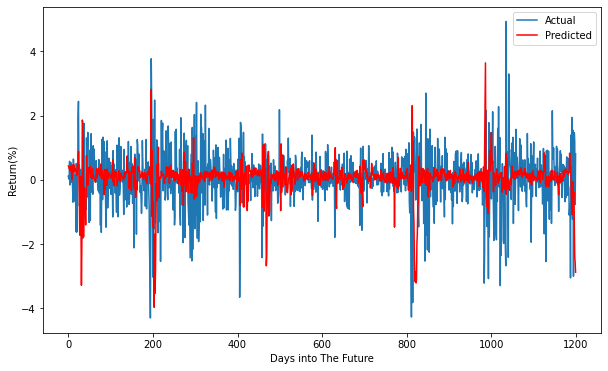

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(test_labels, label='Actual')
plt.plot(test_predictions, label='Predicted', c='r')
plt.ylabel("Return(%)")
plt.xlabel('Days into The Future')
plt.legend()
plt.show()

### BackTest as a strategy

In [17]:
def test_signal(y_pre, threshold=1):
    flag_p = y_pre > threshold
    flag_n = y_pre < -threshold
    return (flag_p, flag_n)

def stra_performance(flag_n, flag_p, ret_23, start_num=2000, end_num=3000, label='long-short', mode='test'):
    stra_ret = np.zeros(len(ret_23))
    # flag = (trends[11] > 0) & (trends[11]<5)
    # flag_1 = (trends_1[11] < 0) & (trends_1[11]>-5)
    dates = range(len(ret_23))
    flag_p = flag_p.squeeze()
    flag_n = flag_n.squeeze()
    stra_ret[flag_n] = ret_23[flag_n]
    stra_ret[flag_p] = -ret_23[flag_p]
    earnings  = [0]
    count_trades = np.count_nonzero(stra_ret)
    print(label, ": ")
    print("# of trading：", count_trades, ";   winning rate：", np.count_nonzero(stra_ret > 0) / count_trades)
    for i in range(len(stra_ret)):
        earnings.append(stra_ret[i] + earnings[-1])
    tdays = stra_ret != 0
    print("return per trade：", earnings[-1] / count_trades, "; Sharpe：", np.mean(stra_ret[tdays]) / np.std(stra_ret[tdays])*np.sqrt(242))
    plt.plot(earnings, label="Sharpe Ratio = {:.4}".format(np.mean(stra_ret[tdays]) / np.std(stra_ret[tdays])*np.sqrt(242)))
    plt.xlabel("Dates")
    K = int((end_num - start_num) / 5)
    plt.legend()
    plt.ylabel("Return")
    plt.title("Return on {} set".format(mode))
    plt.show()
    
def back_test(start_num=0, end_num=2000, threshold=0.5, mode='test'):
    test_data = cache[mode+'_data'][start_num:end_num]
    test_labels = cache[mode+'_label'][start_num:end_num]
    test_predictions = model.predict(test_data).flatten()
    flag_p, flag_n = test_signal(test_predictions, threshold)
    stra_performance(flag_p, flag_n, test_labels/100, start_num, end_num, mode=mode)
    
    

long-short : 
# of trading： 738 ;   winning rate： 0.7018970189701897
return per trade： 0.006230182534176867 ; Sharpe： 8.43419192096771


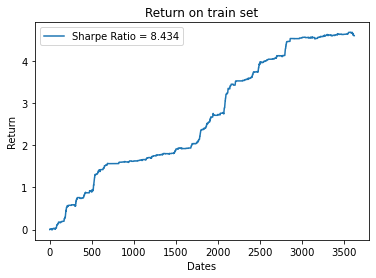

In [28]:
back_test(start_num=0, end_num=4000, threshold=0.3, mode='train')

long-short : 
# of trading： 275 ;   winning rate： 0.4909090909090909
return per trade： -0.00012955583113641403 ; Sharpe： -0.1830397684940919


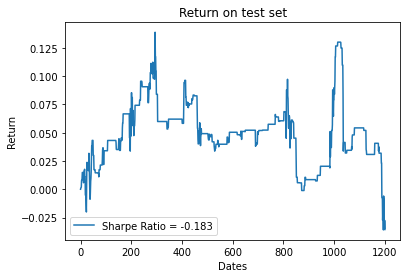

In [29]:
back_test(start_num=0, end_num=4000, threshold=0.3, mode='test')

### Evaluation with MSE and MAE

In [35]:
MSE, _, MAE = model.evaluate(cache['test_data'], cache['test_label'])
print("Model On Test Set: MSE = {}, MAE = {}".format(MSE, MAE))

38/38 [==============================] - 0s 10ms/step - loss: 0.9946 - right_direction: 50.0955 - mae: 0.6754
Model On Test Set: MSE = 0.9946257472038269, MAE = 0.6754195690155029


In [34]:
## If all predictions = 0
print("Benchmark(Null predictor): MSE = {}, MAE = {}".format(np.mean(cache['test_label']**2), np.mean(np.abs(cache['test_label']))))

Benchmark(Null predictor): MSE = 0.7384102489302866, MAE = 0.5886320700033613


* We see that MSE & MAE both higher than benchmark.
* The model overfitted on training set and failed on test set.

In [383]:
# save weights
dirpath = '../Weights'
if os.path.exists(dirpath):
    os.makedirs(dirpath)
filename = 'weights01'
model.save_weights(os.path.join(dirpath, filename))